# User Behavioral Profiling for Insider Threat Detection
This notebook demonstrates the end-to-end process of analyzing the CERT v4.2 dataset for 
insider threat detection.  
We use daily activity aggregation from multiple logs (logon, file, email, device, and http) 
and apply anomaly detection algorithms:
- Isolation Forest  
- One-Class SVM  
- Local Outlier Factor (LOF)  

The goal is to identify unusual user behaviors that may indicate potential insider threats.

### Library Imports
We begin by importing essential Python libraries:
- **Pandas** for data manipulation
- **Scikit-learn** for anomaly detection and preprocessing
- **Matplotlib/Seaborn** for visualization


In [27]:
# ================================================
# Import Required Libraries
# ================================================

import pandas as pd
import os
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns



## Dataset Exploration  
Before processing, we preview the first few rows of each log file to confirm schema and key 
columns (`user`, `date`, `activity`).  
We also count the total rows in each file to plan memory-efficient strategies. 
For example, `http.csv` is extremely large, so we use **chunking**.


In [28]:
# ================================================
# Load Sample Rows from Each Log File
# This helps us understand the structure of the dataset
# ================================================
DATA_DIR =  r"C:\Siddharth\r4.2"
for f in ["logon.csv", "file.csv", "email.csv", "device.csv", "http.csv"]:
    df = pd.read_csv(os.path.join(DATA_DIR, f), nrows=5)
    print(f"✅ {f} sample rows:\n", df.head(), "\n")


✅ logon.csv sample rows:
                          id                 date     user       pc activity
0  {X1D9-S0ES98JV-5357PWMI}  01/02/2010 06:49:00  NGF0157  PC-6056    Logon
1  {G2B3-L6EJ61GT-2222RKSO}  01/02/2010 06:50:00  LRR0148  PC-4275    Logon
2  {U6Q3-U0WE70UA-3770UREL}  01/02/2010 06:53:04  LRR0148  PC-4124    Logon
3  {I0N5-R7NA26TG-6263KNGM}  01/02/2010 07:00:00  IRM0931  PC-7188    Logon
4  {D1S0-N6FH62BT-5398KANK}  01/02/2010 07:00:00  MOH0273  PC-6699    Logon 

✅ file.csv sample rows:
                          id                 date     user       pc  \
0  {L9G8-J9QE34VM-2834VDPB}  01/02/2010 07:23:14  MOH0273  PC-6699   
1  {H0W6-L4FG38XG-9897XTEN}  01/02/2010 07:26:19  MOH0273  PC-6699   
2  {M3Z0-O2KK89OX-5716MBIM}  01/02/2010 08:12:03  HPH0075  PC-2417   
3  {E1I4-S4QS61TG-3652YHKR}  01/02/2010 08:17:00  HPH0075  PC-2417   
4  {D4R7-E7JL45UX-0067XALT}  01/02/2010 08:24:57  HSB0196  PC-8001   

       filename                                            content  
0

**Data Exploration & Size Check**

The row counts highlight that `http.csv` is extremely large (millions of records), which motivates the use of **chunking** during feature extraction.


In [29]:
# ================================================
# Count Total Rows in Each File
# Useful for estimating memory usage and processing strategies
# ================================================

for f in ["logon.csv", "file.csv", "email.csv", "device.csv", "http.csv"]:
    path = os.path.join(DATA_DIR, f)
    rows = sum(1 for _ in open(path)) - 1
    print(f"{f}: {rows:,} rows")


logon.csv: 854,859 rows
file.csv: 445,581 rows
email.csv: 2,629,979 rows
device.csv: 405,380 rows
http.csv: 28,434,423 rows


## Logon Data Analysis
We start with **logon.csv** since it reflects core user access patterns.  
- Top 10 users by logon activity  
- Activity heatmap (day vs hour)  
- Event type distribution  


Unique users in logon logs: 1000


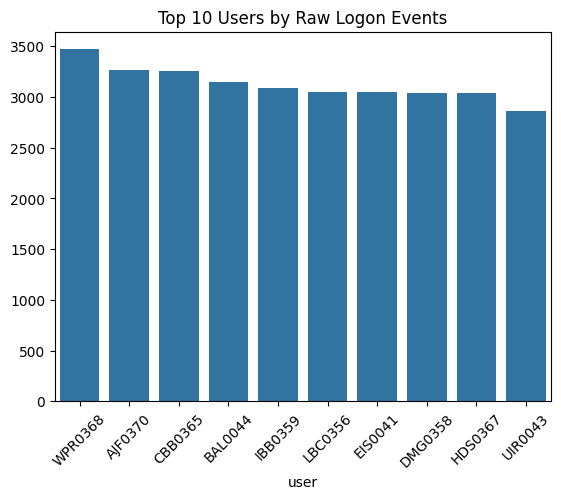

In [30]:
# ================================================
# Logon Data Exploration
# ================================================

logon_df = pd.read_csv(os.path.join(DATA_DIR, "logon.csv"))
print("Unique users in logon logs:", logon_df['user'].nunique())  # Count number of unique users in logon logs

logon_counts = logon_df['user'].value_counts().head(10) # Top 10 users by raw logon events
sns.barplot(x=logon_counts.index, y=logon_counts.values)
plt.title("Top 10 Users by Raw Logon Events")
plt.xticks(rotation=45)
plt.show()


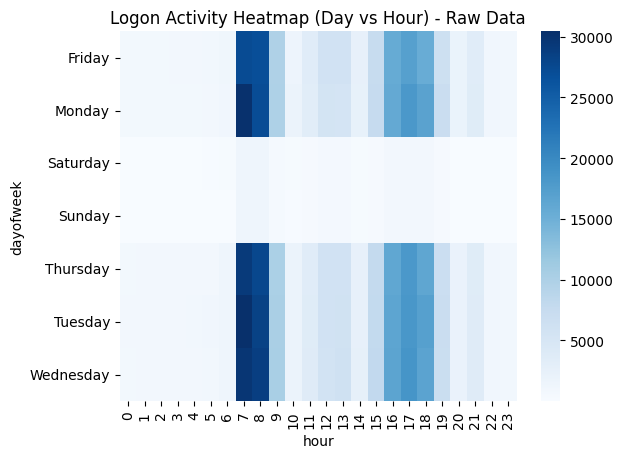

In [31]:
logon_df['date'] = pd.to_datetime(logon_df['date'], errors='coerce')
logon_df['dayofweek'] = logon_df['date'].dt.day_name()
logon_df['hour'] = logon_df['date'].dt.hour

pivot = logon_df.pivot_table(index='dayofweek', columns='hour', values='user', aggfunc='count')
sns.heatmap(pivot, cmap="Blues")
plt.title("Logon Activity Heatmap (Day vs Hour) - Raw Data")
plt.show()


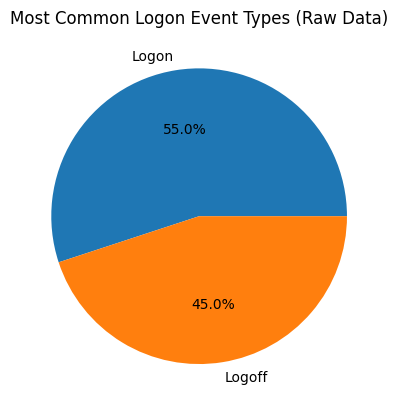

In [32]:
logon_df['activity'].value_counts().head(5).plot(kind='pie', autopct='%1.1f%%')
plt.title("Most Common Logon Event Types (Raw Data)")
plt.ylabel("")
plt.show()



## HTTP Logs with Chunked Processing

**Inspiration:** Reading large CSVs in chunks (pandas docs + Real Python tutorial).  
- Source: https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html#iterating-through-files-chunk-by-chunk  
- Tutorial: https://realpython.com/working-with-large-csv-files-in-python/  

**Outcome:** Learned how to iterate over large files safely.  
**Improvement:** Added aggregation per `(user,date)` to create `web_visits` feature for HTTP logs.



In [33]:
from collections import defaultdict

def daily_counts_chunked_http(file_path):
    agg_dict = defaultdict(int)

    for chunk in pd.read_csv(file_path, chunksize=500_000):
        chunk['date'] = pd.to_datetime(chunk['date'], errors='coerce')
        chunk.dropna(subset=['date', 'user'], inplace=True)
        chunk['date'] = chunk['date'].dt.date  
        grouped = chunk.groupby(['user', 'date']).size()   # Groups by (user, date) and counts occurrences
        for (user, date), count in grouped.items():
            agg_dict[(user, date)] += count

    # Convert to DataFrame
    http_feat = pd.DataFrame(
        [(user, date, count) for (user, date), count in agg_dict.items()],
        columns=['user', 'date', 'web_visits']
    )
    return http_feat

# Usage:
http_feat = daily_counts_chunked_http(os.path.join(DATA_DIR, "http.csv"))
print("✅ HTTP feature extracted:", http_feat.shape)


✅ HTTP feature extracted: (329845, 3)


In [34]:
# Function
def parse_and_prepare(df, time_col='date'):
    df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
    return df.dropna(subset=[time_col])

# Load your dataframes
DATA_DIR = r"C:\Siddharth\r4.2"

logon_df = parse_and_prepare(pd.read_csv(os.path.join(DATA_DIR, "logon.csv")), 'date')
file_df  = parse_and_prepare(pd.read_csv(os.path.join(DATA_DIR, "file.csv")), 'date')
email_df = parse_and_prepare(pd.read_csv(os.path.join(DATA_DIR, "email.csv")), 'date')
device_df = parse_and_prepare(pd.read_csv(os.path.join(DATA_DIR, "device.csv")), 'date')

# Daily feature counts
def daily_counts(df, label):
    df['date'] = df['date'].dt.date  # Convert to just date
    return df.groupby(['user', 'date']).size().reset_index(name=label)

logon_feat = daily_counts(logon_df, "logon_count")
file_feat = daily_counts(file_df, "file_count")
email_feat = daily_counts(email_df, "email_sent")
device_feat = daily_counts(device_df, "usb_events")

# HTTP handled separately in chunks
http_feat = daily_counts_chunked_http(os.path.join(DATA_DIR, "http.csv"))


In [35]:
dfs = [logon_feat, file_feat, email_feat, http_feat, device_feat]
user_daily = dfs[0]
for df in dfs[1:]:
    user_daily = pd.merge(user_daily, df, on=['user', 'date'], how='outer')

user_daily.fillna(0, inplace=True)

## Exploratory Data Analysis
We visualize feature distributions and correlations to understand 
baseline behavior before anomaly detection.


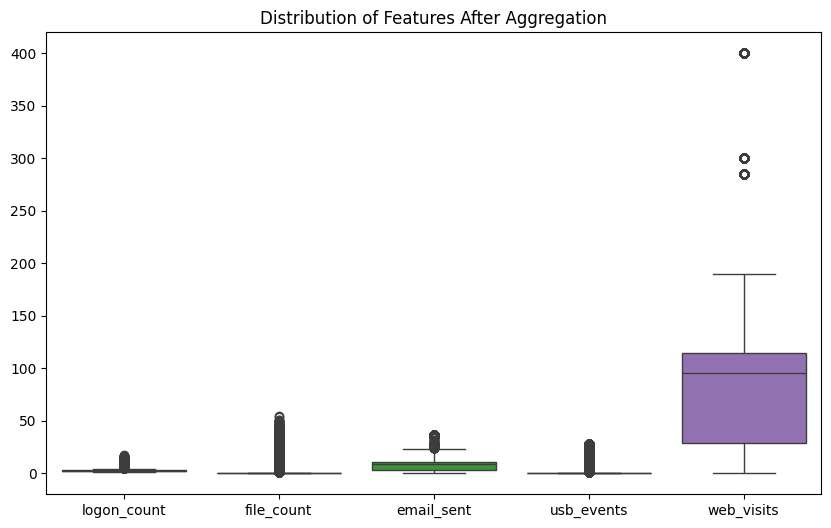

In [36]:
plt.figure(figsize=(10,6))
sns.boxplot(data=user_daily[['logon_count','file_count','email_sent','usb_events','web_visits']])
plt.title("Distribution of Features After Aggregation")
plt.show()


In [37]:
print("✅ user_daily shape:", user_daily.shape)
print(user_daily.head())
print(user_daily.describe())


✅ user_daily shape: (330452, 7)
      user        date  logon_count  file_count  email_sent  web_visits  \
0  AAE0190  2010-01-04            2         0.0        14.0       143.0   
1  AAE0190  2010-01-05            2         0.0        13.0       143.0   
2  AAE0190  2010-01-06            2         0.0        14.0       143.0   
3  AAE0190  2010-01-07            2         0.0        14.0       143.0   
4  AAE0190  2010-01-08            2         0.0        13.0       143.0   

   usb_events  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
         logon_count     file_count     email_sent     web_visits  \
count  330452.000000  330452.000000  330452.000000  330452.000000   
mean        2.586938       1.348399       7.958732      86.047060   
std         1.385173       4.697557       5.291266      57.281695   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.000000       3.000000      29.000000   
50%    

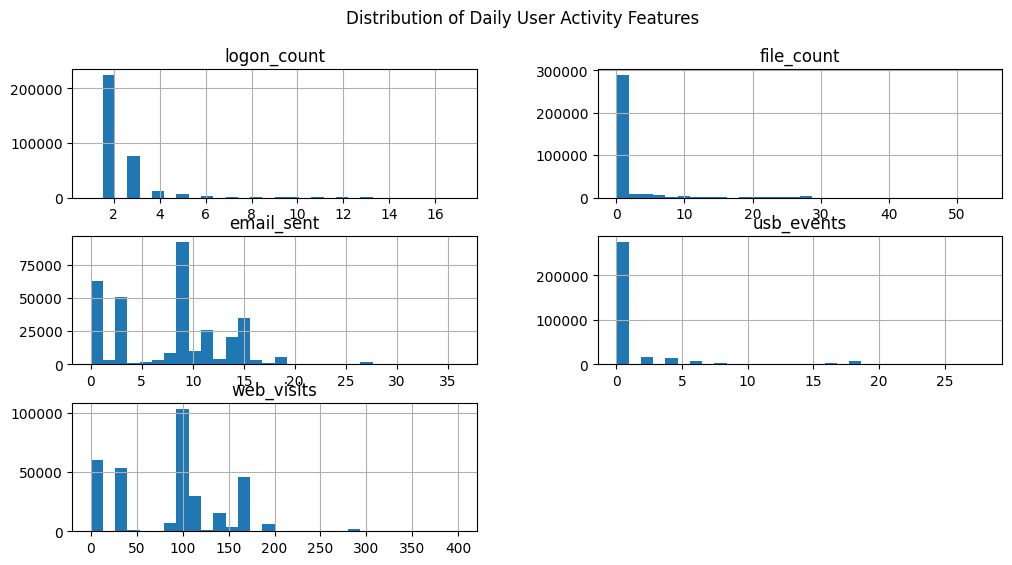

In [38]:
user_daily[['logon_count','file_count','email_sent','usb_events','web_visits']].hist(
    bins=30, figsize=(12,6))
plt.suptitle("Distribution of Daily User Activity Features")
plt.show()


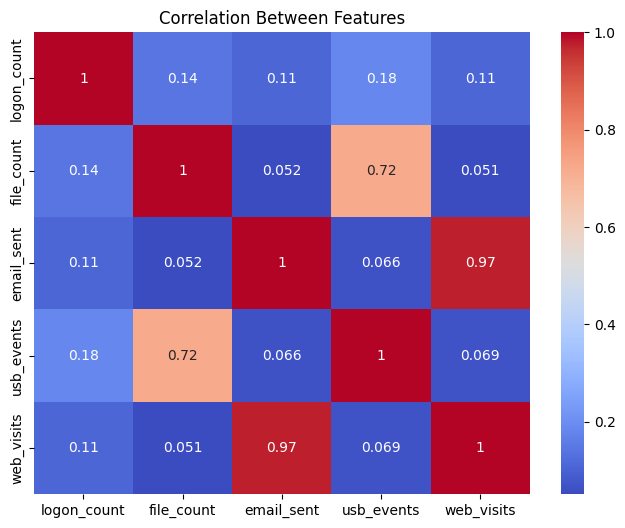

In [39]:
plt.figure(figsize=(8,6))
sns.heatmap(user_daily[['logon_count','file_count','email_sent','usb_events','web_visits']].corr(),
            annot=True, cmap="coolwarm")
plt.title("Correlation Between Features")
plt.show()


## Anomaly Detection
We apply three different anomaly detection methods:
- **One-Class SVM**: boundary-based separation
- **Local Outlier Factor (LOF)**: density-based outlier detection
- **Isolation Forest**: tree-based partitioning


In [40]:
from sklearn.svm import OneClassSVM

# Scale features
features = user_daily.drop(['user','date'], axis=1)   # Scale features before anomaly detection
scaled = StandardScaler().fit_transform(features)     # StandardScaler ensures each feature contributes equally

# One-Class SVM
svm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
user_daily['svm_anomaly'] = svm.fit_predict(scaled)
user_daily['svm_anomaly'] = user_daily['svm_anomaly'].apply(lambda x: 1 if x == -1 else 0)

print("✅ One-Class SVM anomalies Detected:", user_daily['svm_anomaly'].sum())


✅ One-Class SVM anomalies Detected: 21194


In [41]:
from sklearn.neighbors import LocalOutlierFactor

# Scale features
features = user_daily.drop(['user','date'], axis=1)       # Scale features before anomaly detection
scaled = StandardScaler().fit_transform(features)          # StandardScaler ensures each feature contributes equally

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
user_daily['lof_anomaly'] = lof.fit_predict(scaled)
user_daily['lof_anomaly'] = user_daily['lof_anomaly'].apply(lambda x: 1 if x == -1 else 0)

print("✅ LOF anomalies Detected:", user_daily['lof_anomaly'].sum())   #detected anomalies


✅ LOF anomalies Detected: 16521


c:\Siddharth\r4.2\.venv\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


In [42]:
from sklearn.preprocessing import StandardScaler        
from sklearn.ensemble import IsolationForest        

# Scale features
features = user_daily.drop(['user','date'], axis=1)
scaled = StandardScaler().fit_transform(features)             # StandardScaler ensures each feature contributes equally

# Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)
user_daily['iso_anomaly'] = iso.fit_predict(scaled)
user_daily['iso_anomaly'] = user_daily['iso_anomaly'].apply(lambda x: 1 if x == -1 else 0)

print("✅ Isolation Forest anomalies detected:", user_daily['iso_anomaly'].sum())   #print accuracy


✅ Isolation Forest anomalies detected: 16516


## Algorithm Comparison
We compare agreement between algorithms and apply **majority voting** 
(≥2 algorithms must agree to flag an anomaly).  
This reduces false positives.


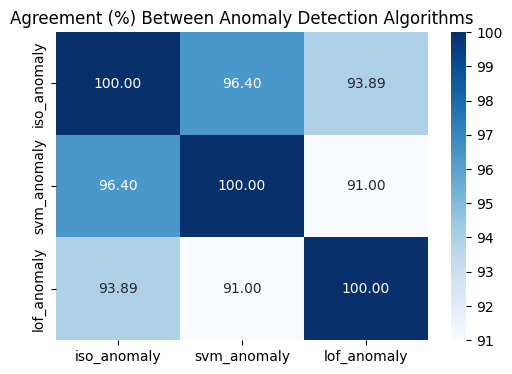

In [43]:
algorithms = ['iso_anomaly','svm_anomaly','lof_anomaly']
agreement_matrix = pd.DataFrame(index=algorithms, columns=algorithms)

for a in algorithms:
    for b in algorithms:
        agreement = (user_daily[a] == user_daily[b]).mean()
        agreement_matrix.loc[a,b] = round(agreement*100,2)

plt.figure(figsize=(6,4))
sns.heatmap(agreement_matrix.astype(float), annot=True, cmap="Blues", fmt=".2f")
plt.title("Agreement (%) Between Anomaly Detection Algorithms")
plt.show()


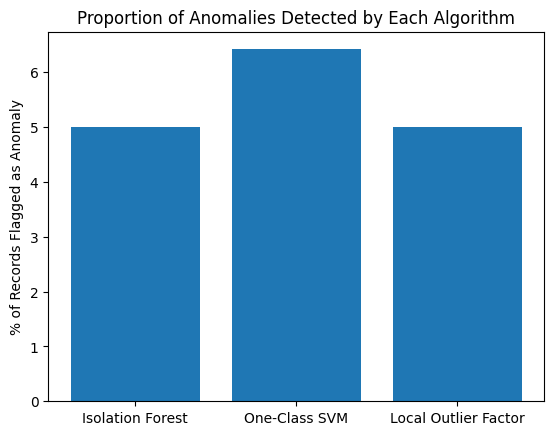

In [44]:
# % anomalies flagged by each algorithm
anomaly_props = {
    'Isolation Forest': user_daily['iso_anomaly'].mean()*100,
    'One-Class SVM': user_daily['svm_anomaly'].mean()*100,
    'Local Outlier Factor': user_daily['lof_anomaly'].mean()*100
}

plt.bar(anomaly_props.keys(), anomaly_props.values())
plt.title("Proportion of Anomalies Detected by Each Algorithm")
plt.ylabel("% of Records Flagged as Anomaly")
plt.show()
#% to 10 and print percentage in bar plot


In [45]:
# Majority voting: if 2+ algorithms flag as anomaly, mark consensus anomaly
user_daily['consensus'] = user_daily[['iso_anomaly','svm_anomaly','lof_anomaly']].sum(axis=1)
user_daily['consensus'] = user_daily['consensus'].apply(lambda x: 1 if x >= 2 else 0)

# Compare each algorithm against consensus
for alg in algorithms:
    acc = (user_daily[alg] == user_daily['consensus']).mean()
    print(f"{alg} alignment with consensus: {acc:.2f}")


iso_anomaly alignment with consensus: 1.00
svm_anomaly alignment with consensus: 0.97
lof_anomaly alignment with consensus: 0.94


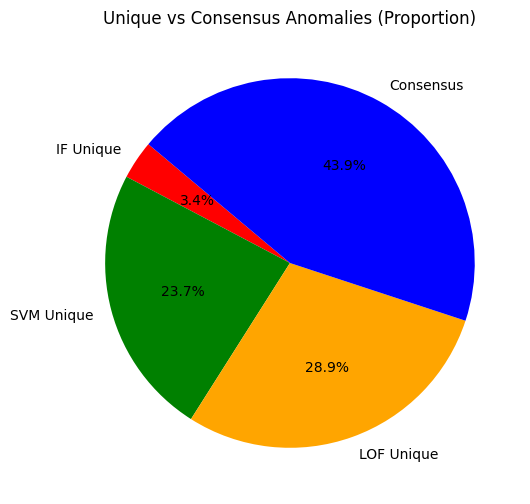

In [46]:
# Unique anomalies per algorithm
unique_iso = ((user_daily['iso_anomaly']==1) & 
              (user_daily['svm_anomaly']==0) & 
              (user_daily['lof_anomaly']==0)).sum()

unique_svm = ((user_daily['svm_anomaly']==1) & 
              (user_daily['iso_anomaly']==0) & 
              (user_daily['lof_anomaly']==0)).sum()

unique_lof = ((user_daily['lof_anomaly']==1) & 
              (user_daily['iso_anomaly']==0) & 
              (user_daily['svm_anomaly']==0)).sum()

consensus = (user_daily['consensus']==1).sum()

plt.figure(figsize=(6,6))
plt.pie([unique_iso, unique_svm, unique_lof, consensus],
        labels=['IF Unique','SVM Unique','LOF Unique','Consensus'],
        autopct='%1.1f%%', startangle=140, colors=['red','green','orange','blue'])
plt.title("Unique vs Consensus Anomalies (Proportion)")
plt.show()


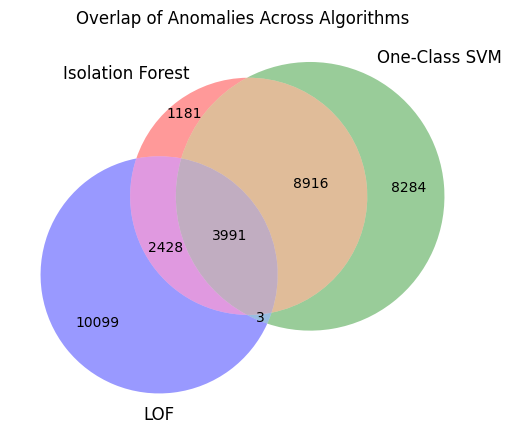

In [47]:
from matplotlib_venn import venn3

iso_set = set(user_daily.index[user_daily['iso_anomaly']==1])
svm_set = set(user_daily.index[user_daily['svm_anomaly']==1])
lof_set = set(user_daily.index[user_daily['lof_anomaly']==1])

plt.figure(figsize=(6,6))
venn3([iso_set, svm_set, lof_set], 
      set_labels=('Isolation Forest','One-Class SVM','LOF'))
plt.title("Overlap of Anomalies Across Algorithms")
plt.show()


## Risk Scoring
We aggregate anomaly counts per user to derive a **risk score**.  
This highlights the top risky users who require further investigation.


C:\Users\siddharth\AppData\Local\Temp\ipykernel_15316\4131969833.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_risky, x='user', y='anomaly_days', palette='Reds_r')


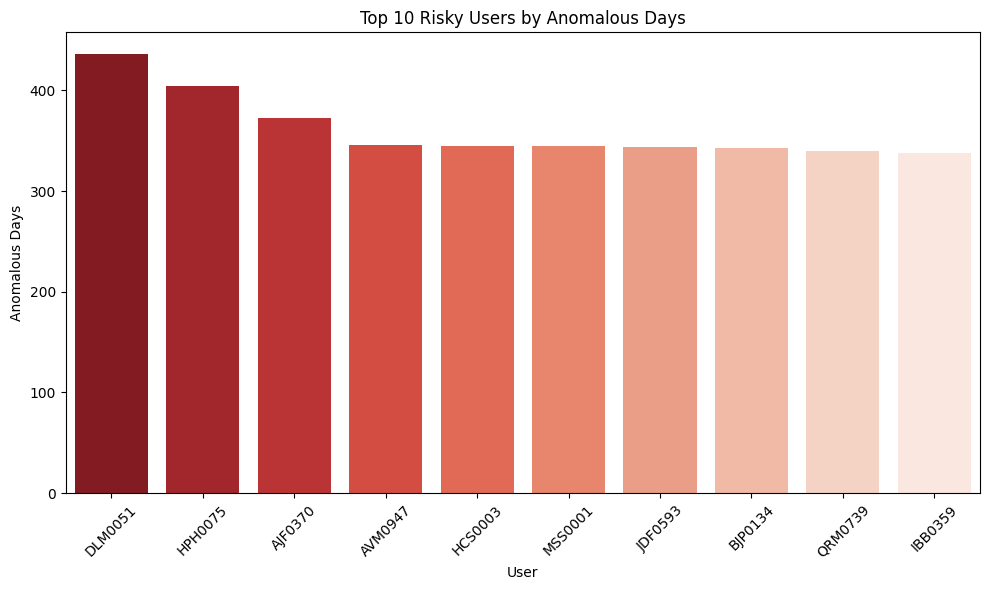

In [48]:
risk_scores = user_daily.groupby('user')['iso_anomaly'].sum().reset_index()
risk_scores.columns = ['user', 'anomaly_days']
top_risky = risk_scores.sort_values(by='anomaly_days', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_risky, x='user', y='anomaly_days', palette='Reds_r')
plt.title("Top 10 Risky Users by Anomalous Days")
plt.xticks(rotation=45)
plt.ylabel("Anomalous Days")
plt.xlabel("User")
plt.tight_layout()
plt.show()

## PCA Visualization
We apply Principal Component Analysis (PCA) for 2D visualization.  
Points flagged as anomalies are shown in red.


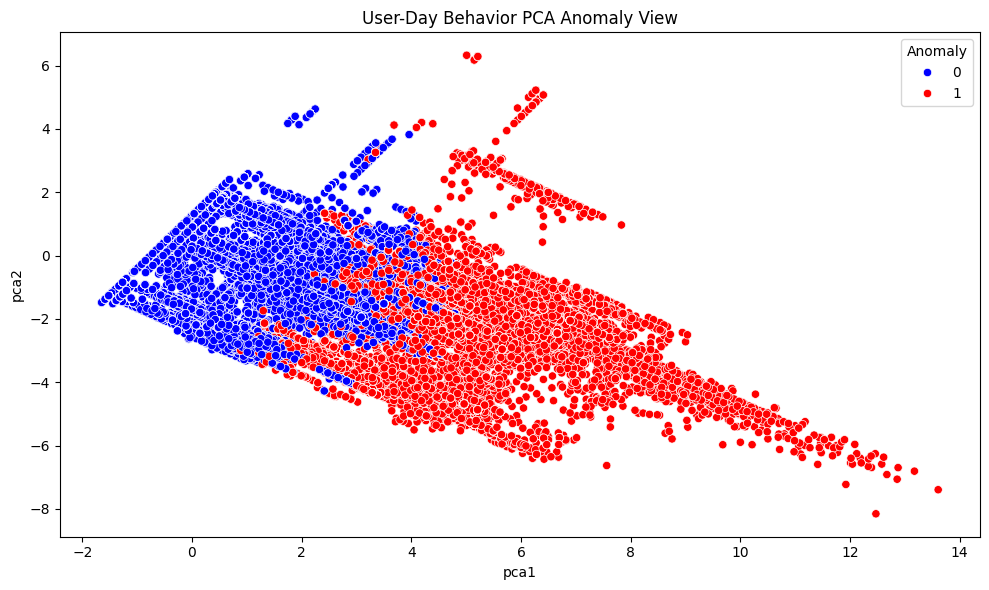

In [49]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled)
user_daily['pca1'] = pca_result[:,0]
user_daily['pca2'] = pca_result[:,1]

plt.figure(figsize=(10,6))
sns.scatterplot(data=user_daily, x='pca1', y='pca2', hue='iso_anomaly', palette={0:'blue',1:'red'})
plt.title("User-Day Behavior PCA Anomaly View")
plt.legend(title="Anomaly")
plt.tight_layout()
plt.show()

## Export
We export the processed dataset (`user_daily_with_anomalies.csv`) 
for downstream analysis and reporting.


In [50]:
user_daily.to_csv("user_daily_with_anomalies.csv", index=False)
